In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sklearn

plt.style.use('seaborn') # matplotlib의 기본 scheme 말고 seaborn scheme을 세팅
sns.set(font_scale=2.5) # 폰트 크기 지정 없어 seaborn의 fort_scale을 사용

import missingno as msno

import warnings
warnings.filterwarnings('ignore') # 워닝 메세지 생략

%matplotlib inline

In [3]:
os.listdir("./input")
# train.csv : 학습에 이용하는 파일
# test.csv : 우리가 학습한 모델을 가지고 예측해야하는 파일
# sample_submission.csv : 예측하고 해당 파일 폼에 맞추어 캐글에 체출해야 함(없음)

['gender_submission.csv', 'test.csv', 'train.csv']

In [4]:
# 판다스로 각 파일 로드

df_train = pd.read_csv("./input/train.csv")
df_test = pd.read_csv("./input/test.csv")
#df_submit = pd.read_csv("./input/sample_submission.csv")
df_submit = pd.read_csv("./input/gender_submission.csv") # 남녀의 사망비율

In [5]:
df_train.shape, df_test.shape, df_submit.shape # .shape 속성으로 데이터의 행, 열 크기 확인

((891, 12), (418, 11), (418, 2))

In [6]:
df_train.columns # .columns 속성으로 해당 데이터프레임을 구성하는 컬럼명 확인
# 컬럼은 총 12개로 예측할 feature는 Survived

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
df_submit.columns
# submit 파일은 2개의 칼럼만 있으면 됌
# 어떤 사람인지 구분하는 PassengerID와 해당 사람이 죽었는지 살앗는지 구별하는 Survived

Index(['PassengerId', 'Survived'], dtype='object')

In [8]:
df_train.head() # .head)() 함수는 불러온 데이터의 상위 5개 행을 출력
# 비슷하게 .tail()는 하위 5개 행을 출력

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
df_submit.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [11]:
# 우리 문제의 feature(특색)은 Pclass, Age, SibSp, Parch, Fare이며
# 예측하려는 target label은 Survived임.

#타이타닉 데이터 Feature 설명

# survival : 생존 유무, target 값(0 = 사망, 1 = 생존)
# pclass : 티켓 클래스 (1 = 1sp, 2 = 2nd, 3 = 3rd)
# sex : 성별
# Age : 나이
# sibsp : 함께 탑승한 형제자매, 배우자 총합
# parch : 함계 탑승한 부모, 자녀 수 총합
# ticket : 티켓 넘버
# fare : 탑승 요금
# cabin : 객실 번호
# bembarked : 탑승 항구

In [12]:
df_train.dtypes # .dtype : 열을 기준으로 데이터 형태 반환

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [13]:
df_train.describe()  # .describe() : 각 feature(레이블)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [14]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [15]:
# 결측치 확인
df_train.isnull().sum()  / df_train.shape[0]
# .isnull() : null값을 찾는 함수
# .sum() : 총 합 구하기

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [16]:
df_test.isnull().sum() / df_test.shape[0]

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

In [17]:
# train set과 test set에 비슷하게 Age에 약 20%, Cabin 피쳐에 약 80%의 결측치 있음

In [18]:
# Target label, Survived 확인
# 타겟 레이블이 어떤 distribution(분포)를 가지고 있는지 확인해야함.
# 지금 처럼 binary classification 문제에서는 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라진다.

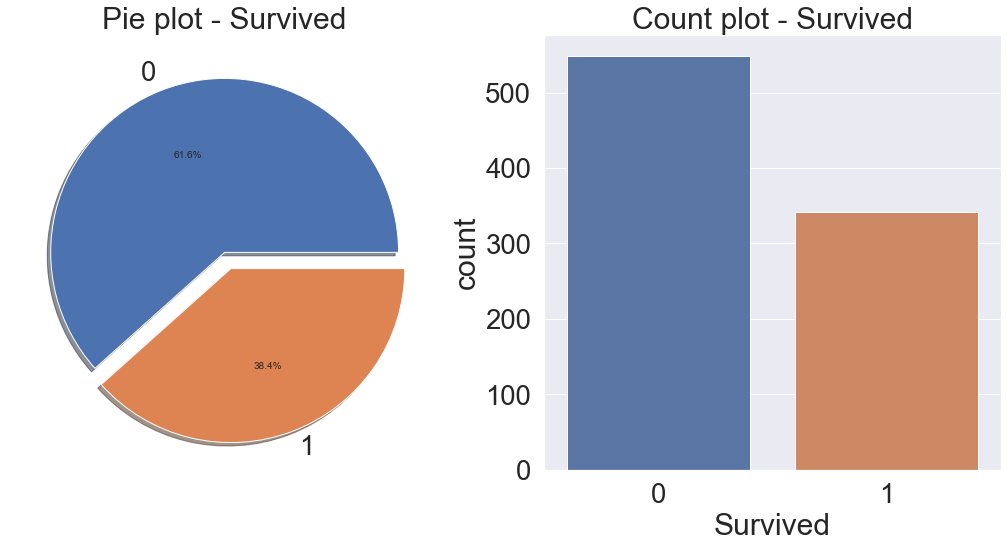

In [19]:
f, ax = plt.subplots(1, 2, figsize = (18, 8))

df_train['Survived'].value_counts().plot.pie(explode = [0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

In [20]:
# 타겟 레이블의 분포가 제법 균일함
# 만약 불균일 하다면(100중 1이 99, 0이 1인 경우 모델이 모든것을 1이라고 해도 정확도가 
# 99%가 나온다.) 모델이 원하는 결과를 줄 수 없음.


In [21]:
# 탐색적 데이터 분석(EDA, Exploratory Data Analysis)
# 데이터를 분석하기 위해선 적절한 시각화가 필요.
# 시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있다.
# 특정 목적에 맞는 소스코드를 정리해두어 참고하면 편함

In [22]:
# Pclsss(티켓 클래스)
# 'Pclass'는 서수형 데이터다. 즉 카테고리면서 순서가 있는 데이터 타입이다.
# 일단 'Pclass'에 따른 생존률의 차이를 살펴본다.

# 엑셀의 피벗 차트와 유사한 작업이며, 'pandas dataframe'에서는 'groupby'를 사용하면
# 쉽게 할수 있고 'pivot'이라는 메소드도 있다.

# 'Pclass', 'Survived'(생존유무)를 가져온 후 pclass로 묶는다.
# 그러면 pclass마다 0, 1이 cout가 되며, 이를 평균하면 각 pclass별 생존률이 나온다

# 아래처럼 count()를 하면 각 class에 몇명이 있는지 확인 가능하고
# sum()을 하면 216명중 생존한(survived = 1)사람의 총합을 주게 됨

df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [23]:
# pclass 그룹 별 생존자 수 합

df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


In [24]:
# 위의 작업을 crosstab으로 편하게 가능

pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True)

# crosstab은 여러 개의 데이터 프레임에서 필요한 열을 가져다가 표를 작성할 수 있다
# 매개변수들
# index : 열(반드시 기입)
# columns : 행(반드시 기입)
# renames : 행이름 변환(default : None)
# colnames : 열이름 변환(default : None)
# margins_ : 행과 열의 가장자리에 합을 기입해서 보여주는 변수(default : None)
# margnis_name : margnis의 이름 설정(default : None)


Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [25]:
# mean은 생존률을 구하게 할 수 있음

df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


<AxesSubplot:xlabel='Pclass'>

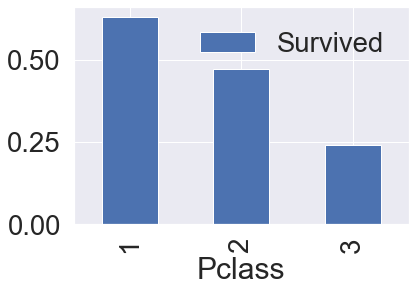

In [26]:
# 위의 자료들을 시각화

df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().plot.bar()
# plot.bar() : 막대 그래프 함수

In [27]:
# 생존에 Pclass가 큰 영향을 미친다고 판단가능,
# 나중에 모델을 세울 때 이 feature를 사용하는 것이 좋을것 같다.

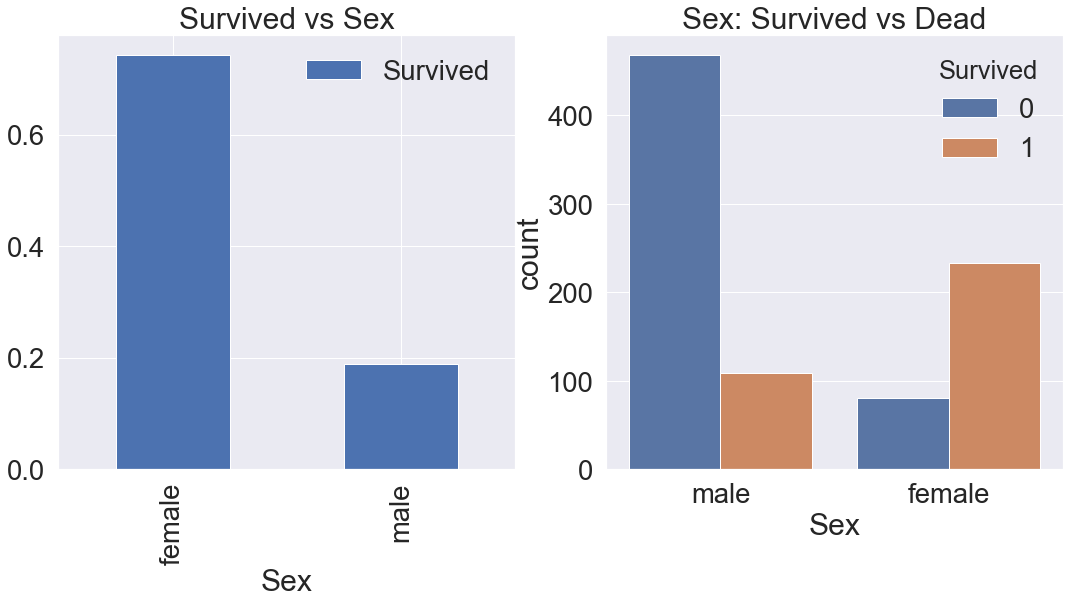

In [28]:
# Sex(성별)

f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

# male : 남자
# female : 여자

In [29]:
# 그래프를 보니 여자의 생존 확률이 높다
# Pclass와 마찬가지로, Sex도 예측 모델이 쓰일 중요한 feature(특성)임을 알 수 있다

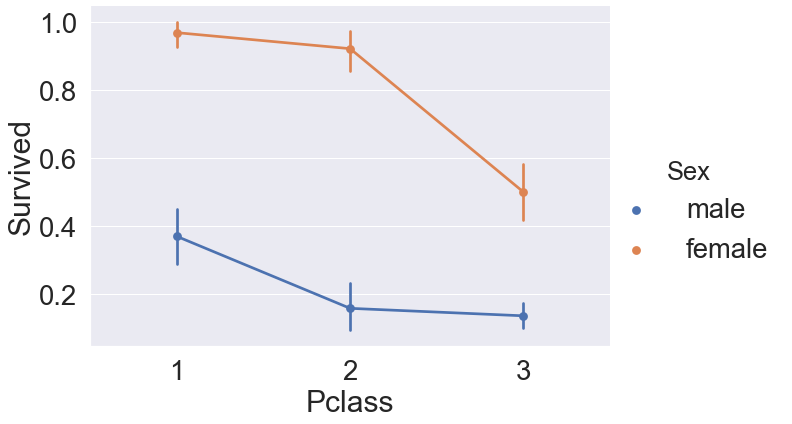

In [30]:
# Both Sex and Pclass
# Sex와 Pclass 두가지에 관하여 생존이 어떻게 달라지는지를 확인함.

sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train, size = 6, aspect = 1.5)
# 여자가 남자보다 살 확률이 더 높다는 것을 확인할 수 있다

In [31]:
# Age
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객 : {:.1f} years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f}'.format(df_train['Age'].mean()))

제일 나이 많은 탑승객 : 80.0 Years
제일 어린 탑승객 : 0.4 years
탑승객 평균 나이 : 29.7


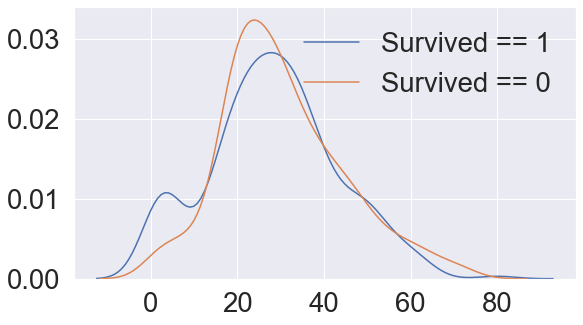

In [32]:
flg, ax = plt.subplots(1, 1, figsize = (9, 5))
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])

plt.show() 

# subplots() 함수는 여러 그래프를 한번에 그려주기 위해 사용
# subplots() 함수는 figure(전체 사이즈)와 axes(서브플롯 각각의 그래프)값을 받을 수 있다.

# [seaborn] 커널 밀도 추정(KDE) : 데이터를 차트화 시킬 때 막대 그래프 만드로는 분포가 안보여서
# 막대 그래프 대신 히스토그램의 분포를 곡선화 시켜주는 커널 밀도 추정을 사용한다.

# seaborn kdeplot의 매개변수는 data(데이터세트)와 shade(곡선 아래의 음영 처리) 두개이다.
# plt.legend : 범례 표시

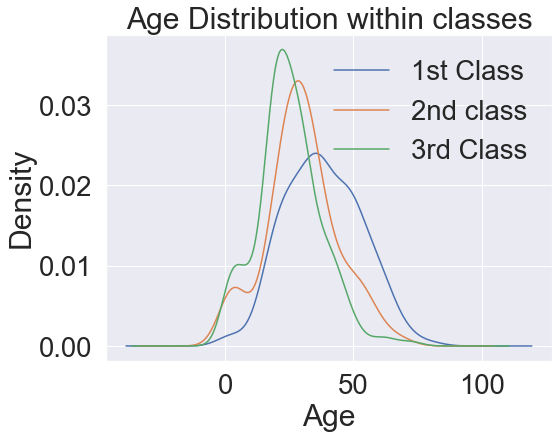

In [33]:
# 어린 나이 구간에서 생존률이 상대적으로 높음

plt.figure(figsize=(8, 6))
# 최소 창의 크기를 가로 8, 세로6으로 새로운 figure을 생성
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd class', '3rd Class'])

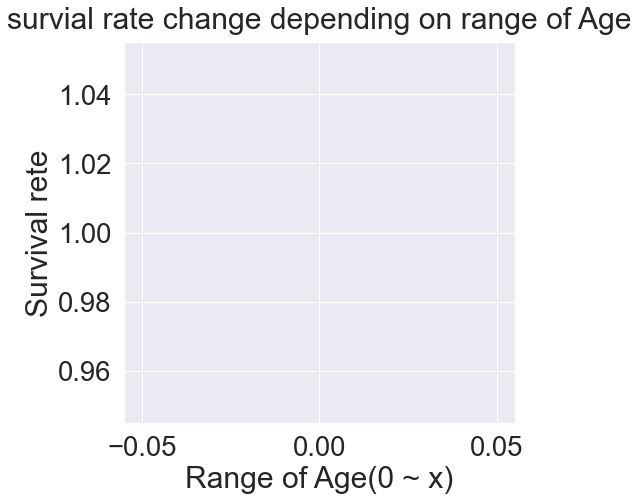

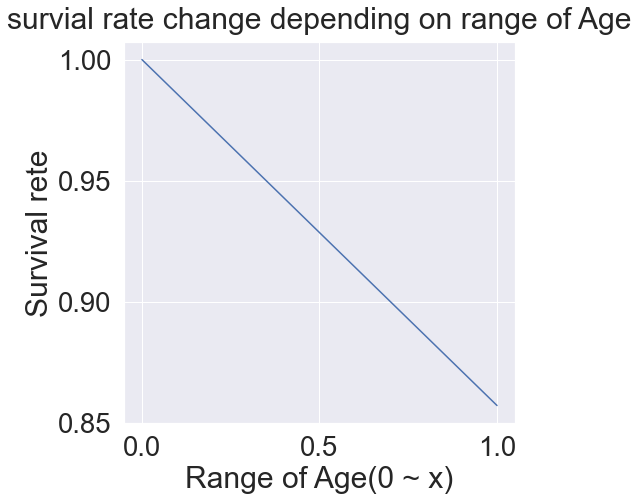

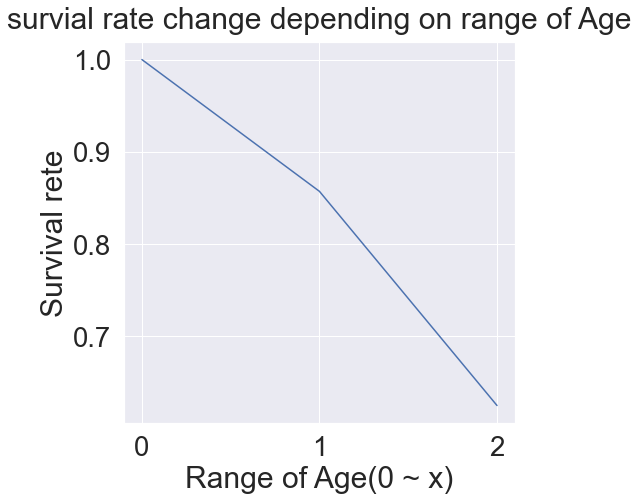

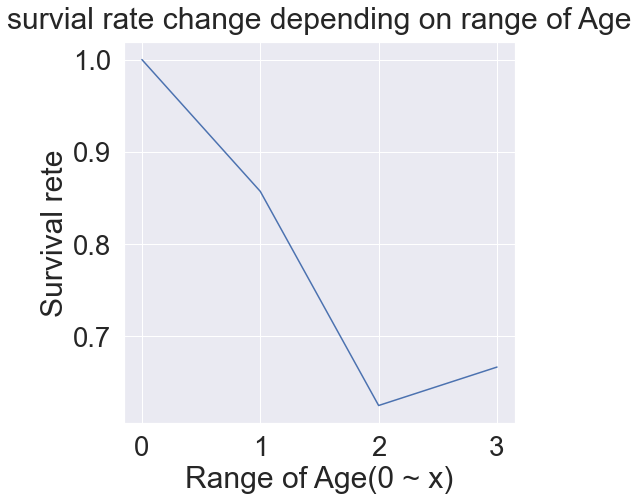

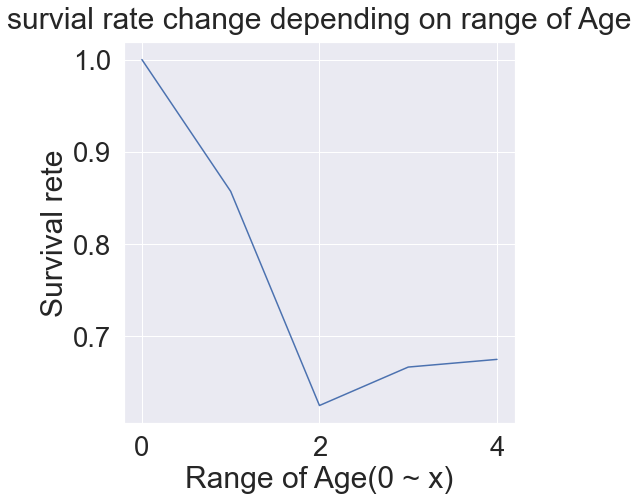

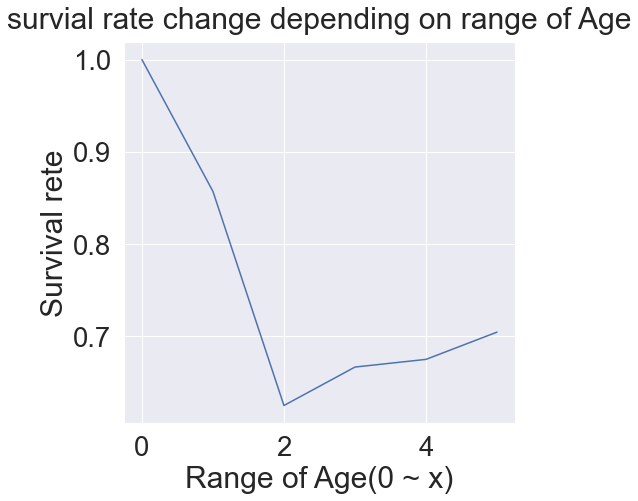

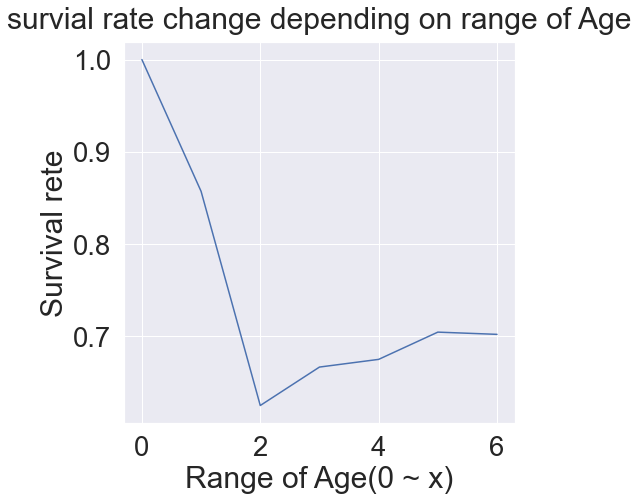

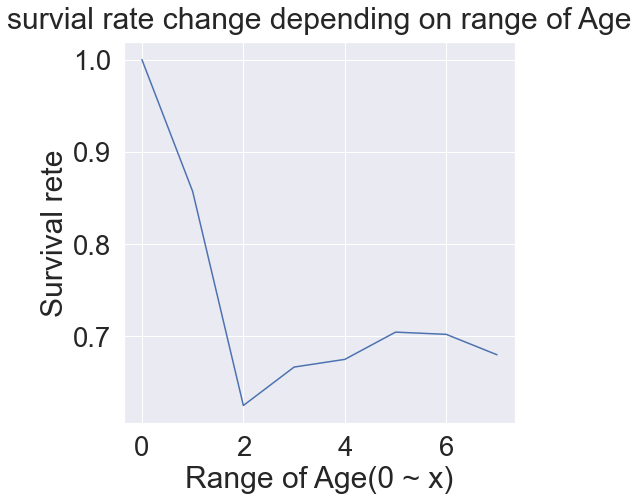

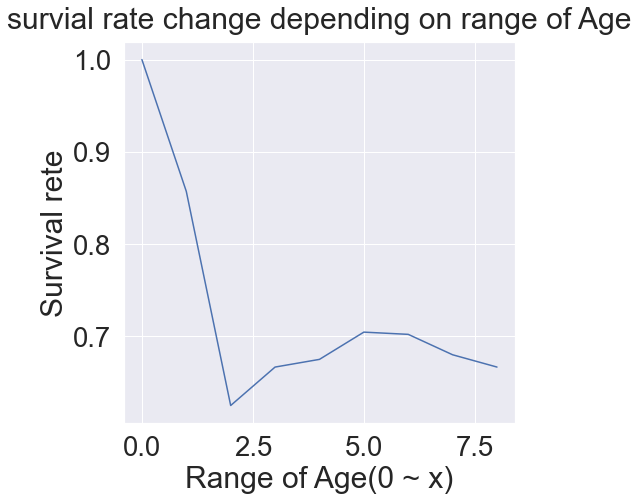

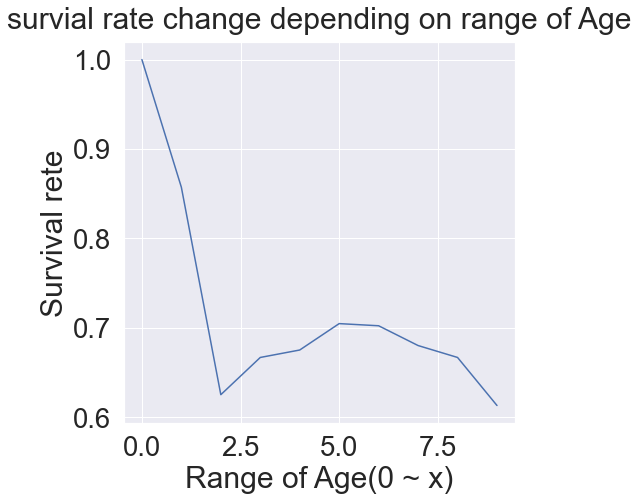

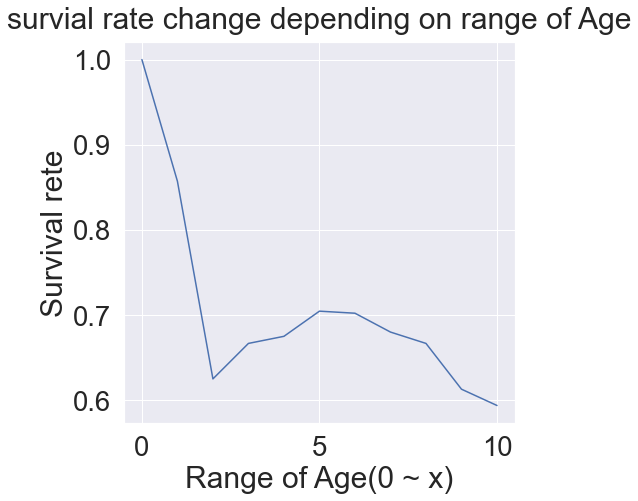

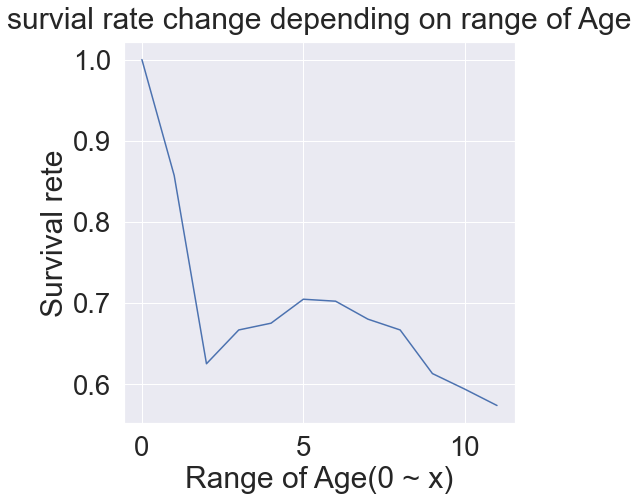

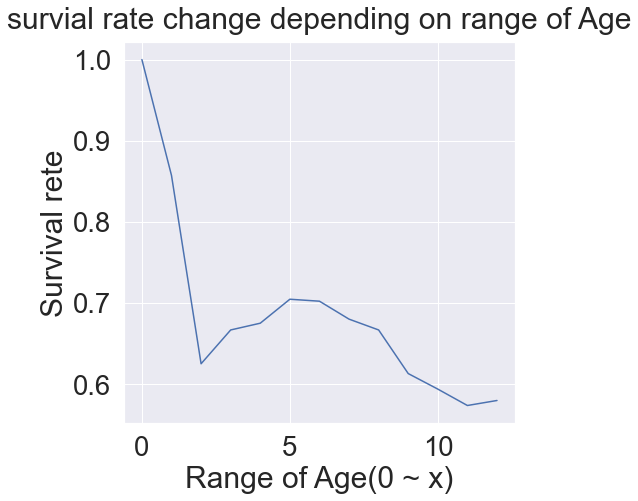

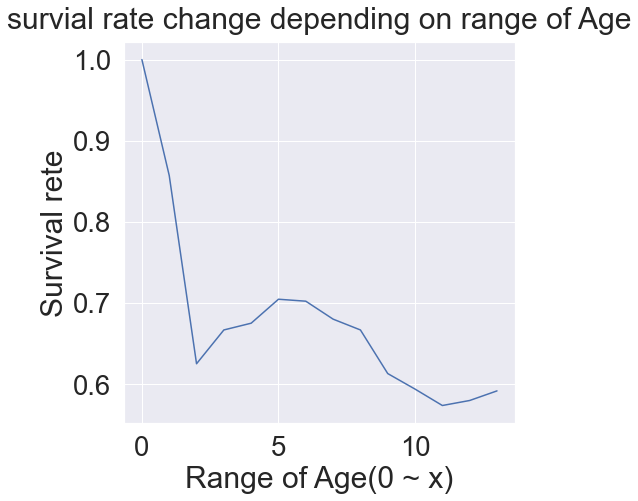

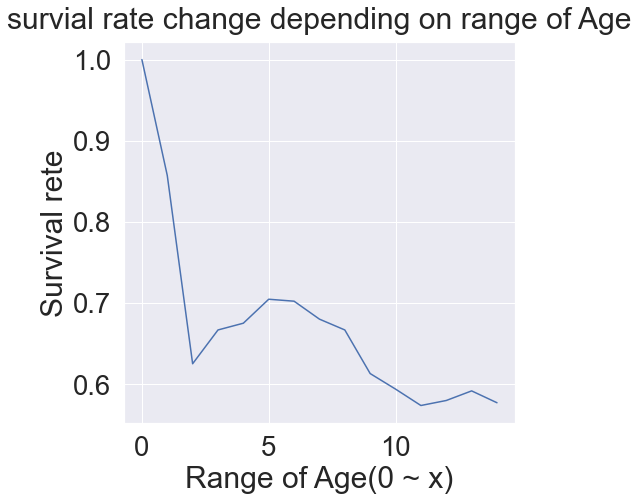

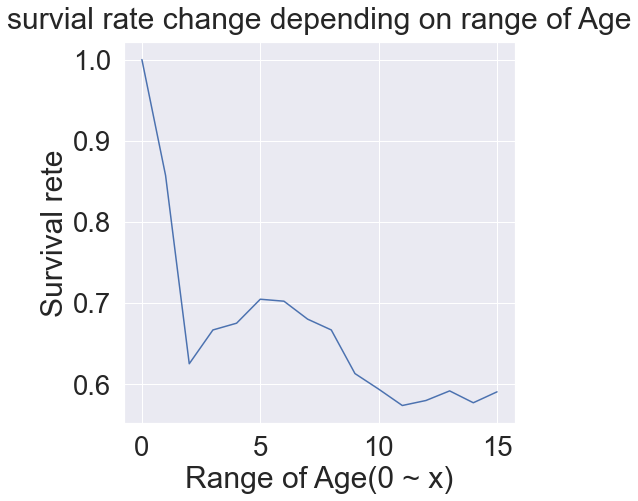

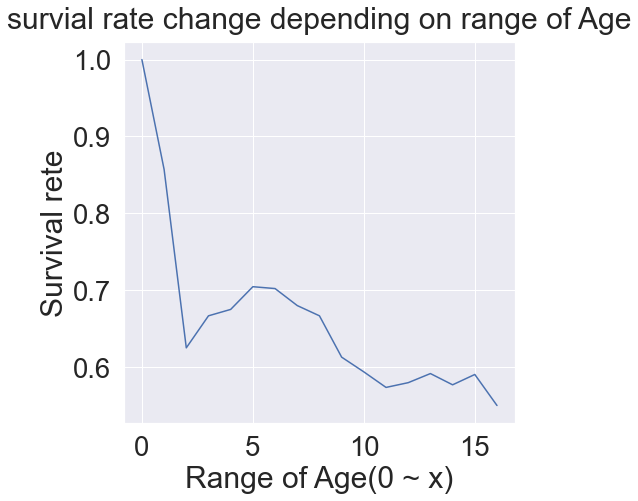

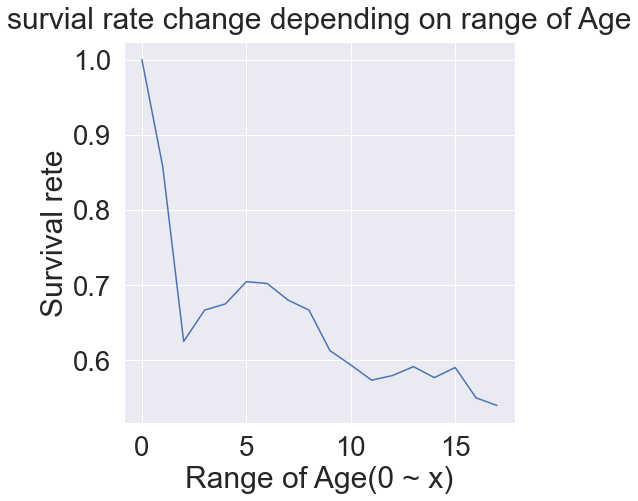

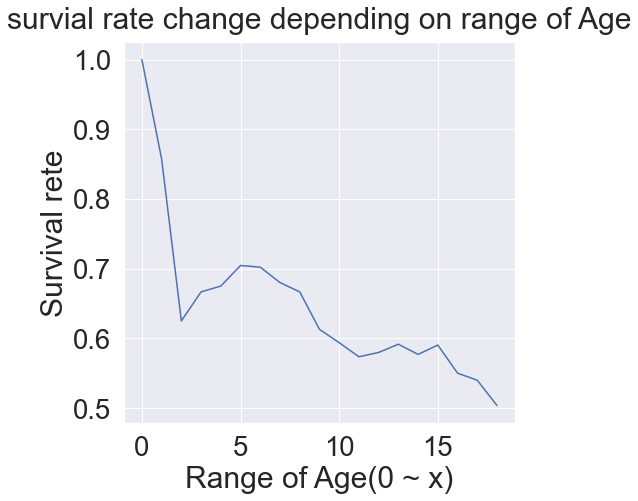

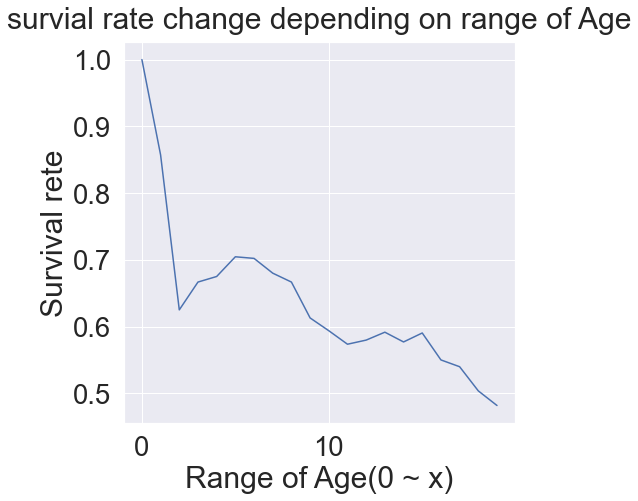

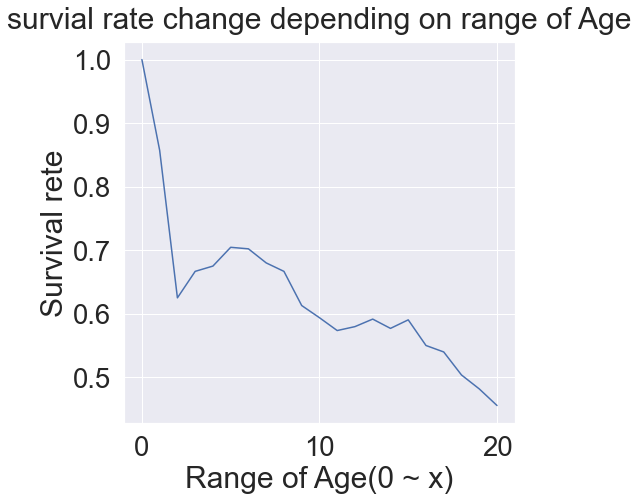

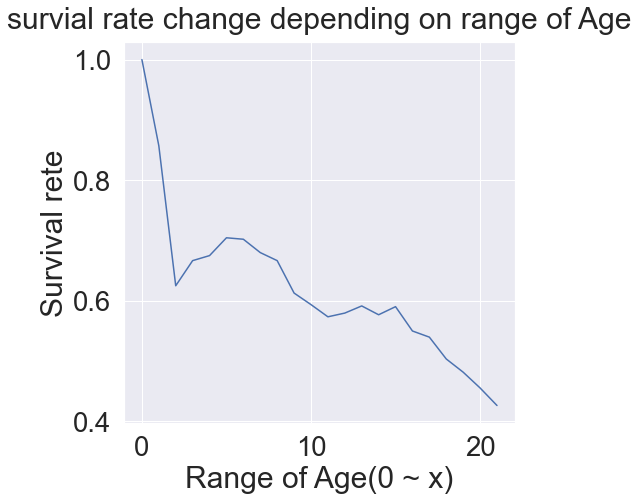

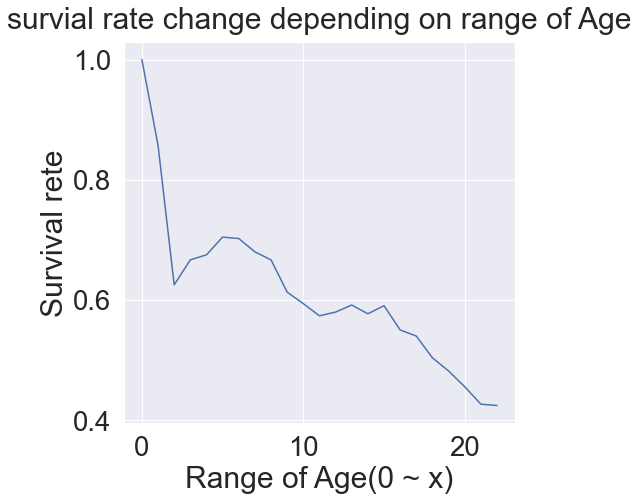

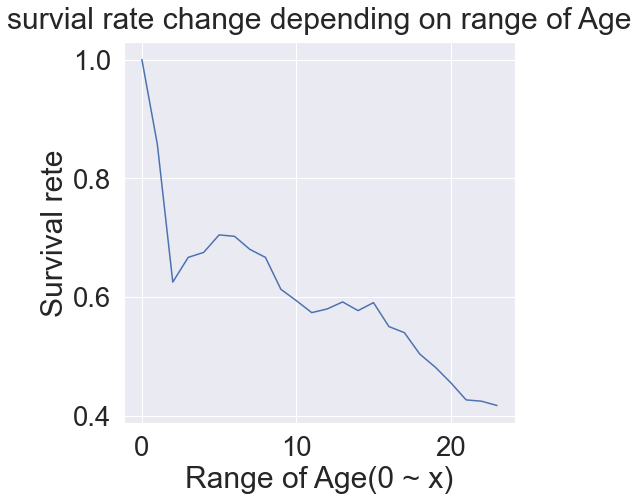

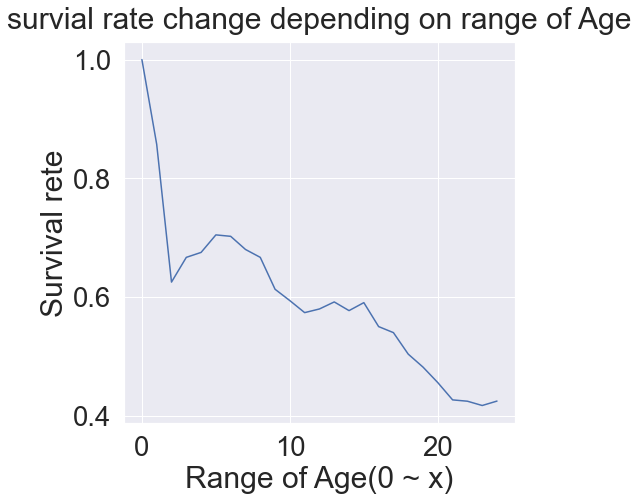

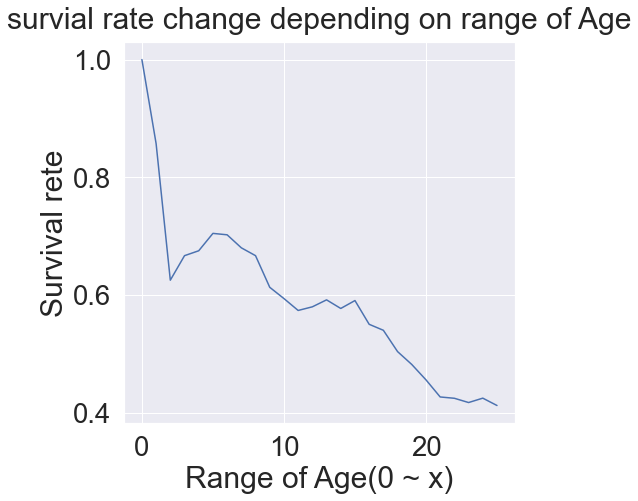

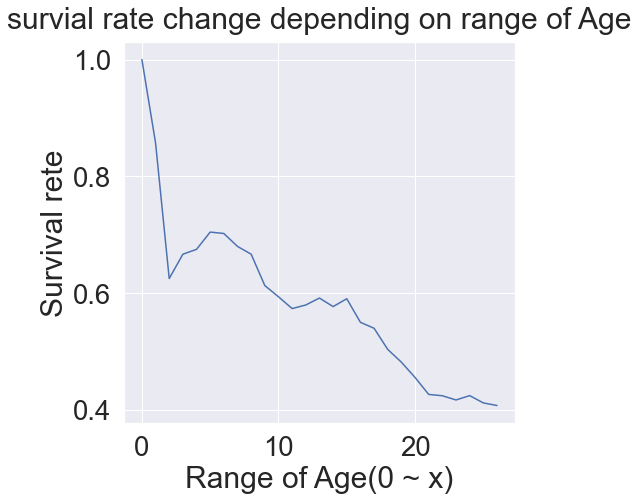

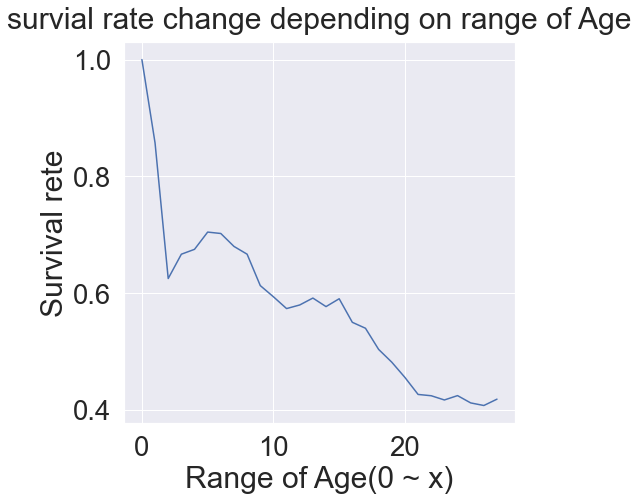

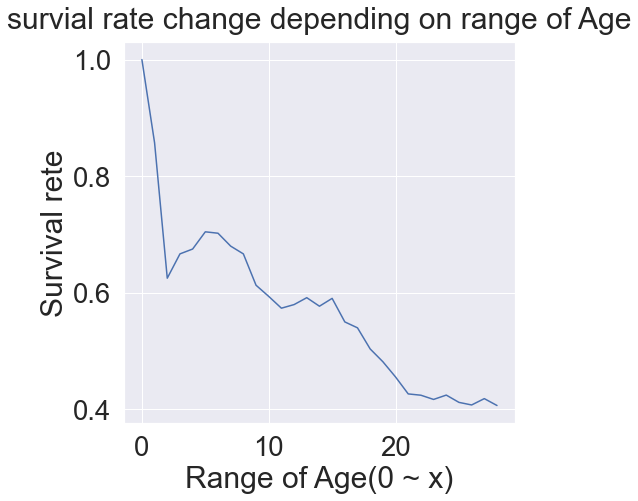

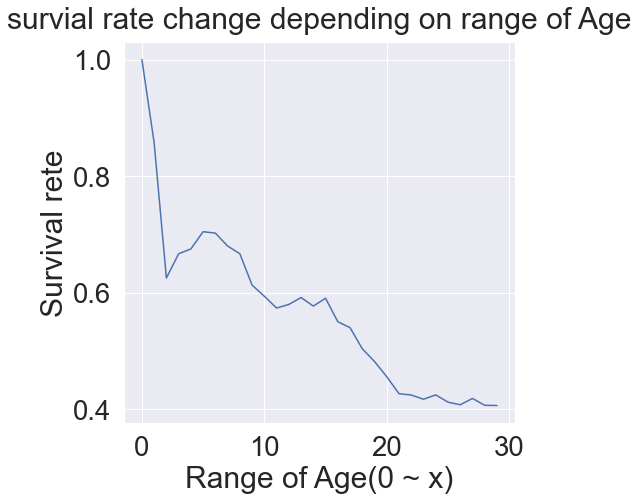

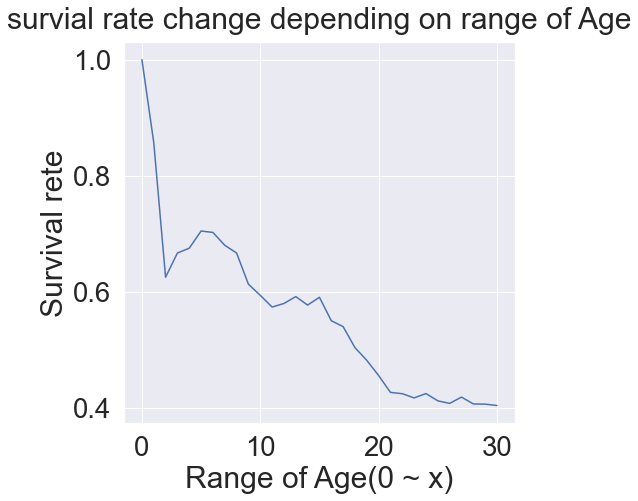

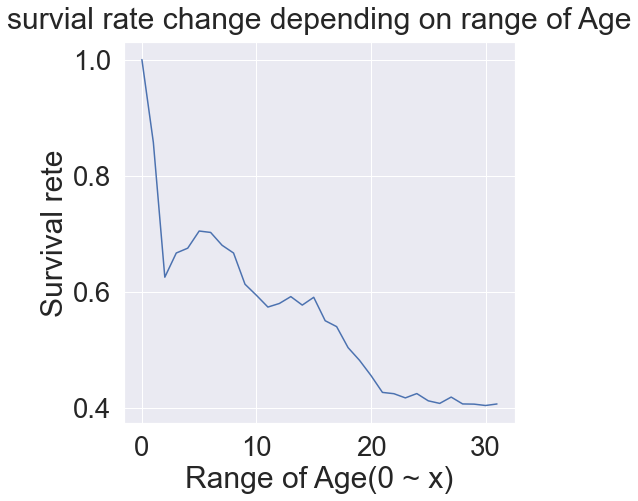

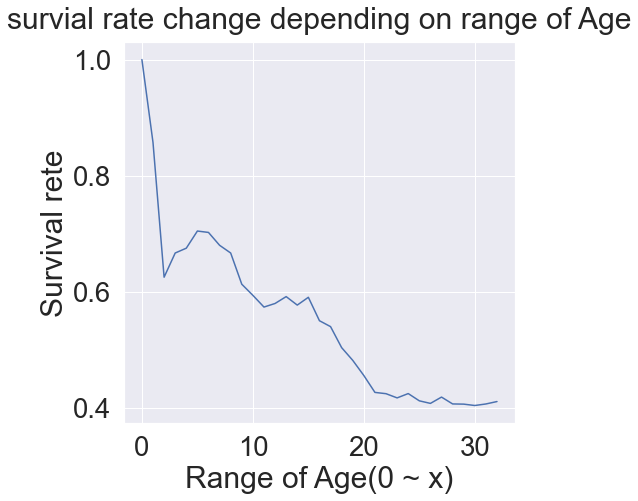

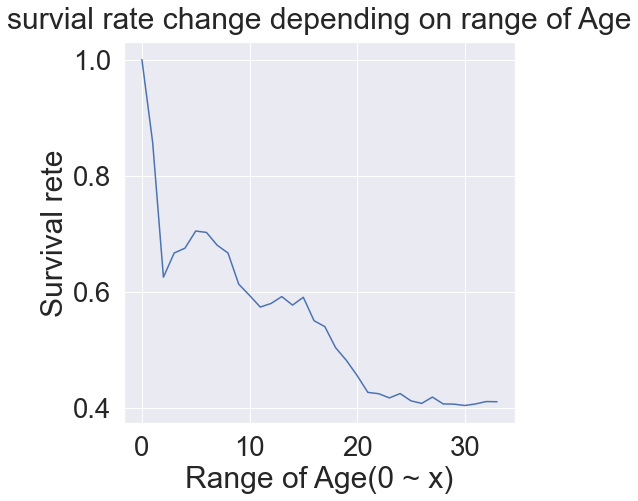

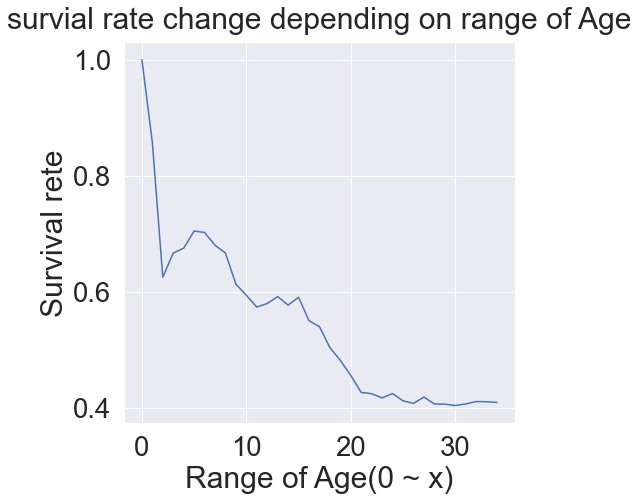

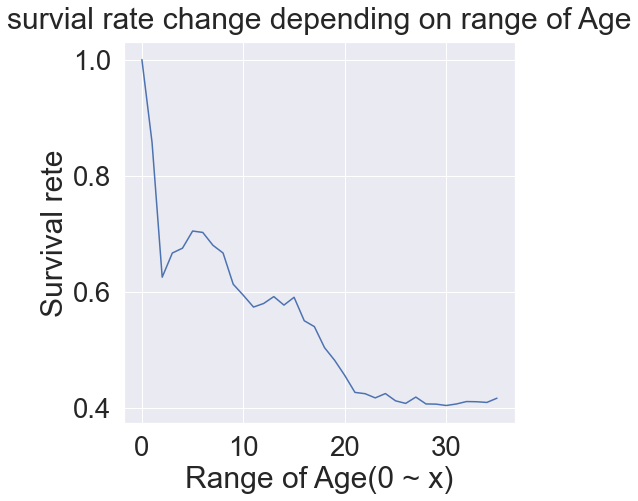

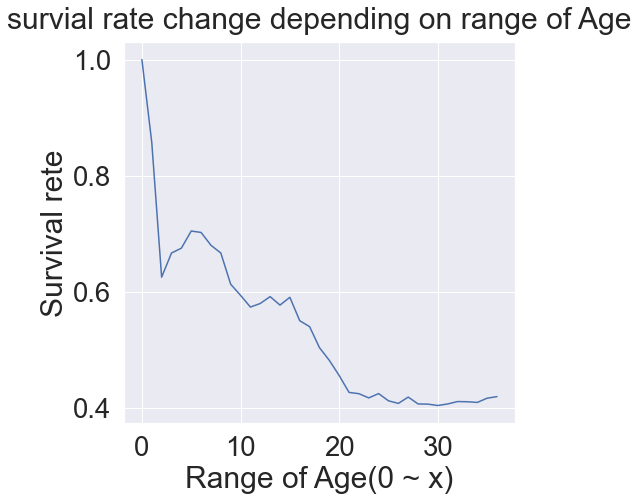

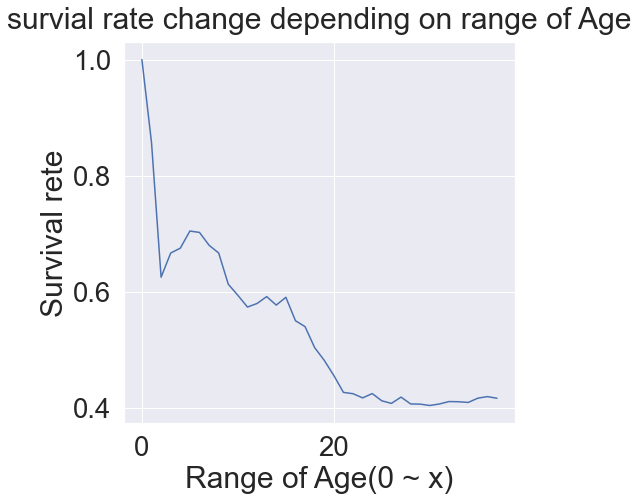

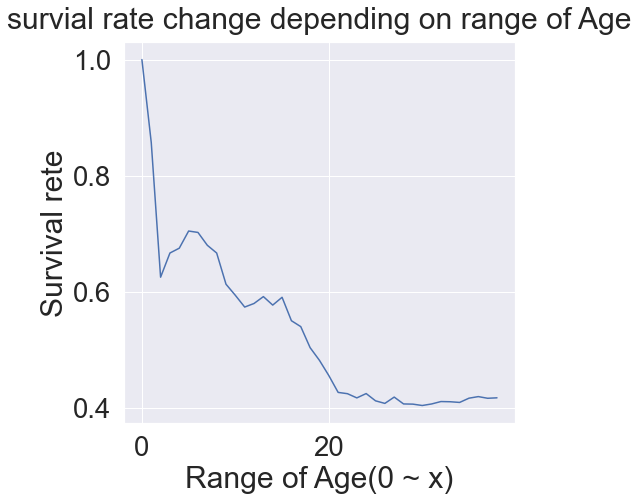

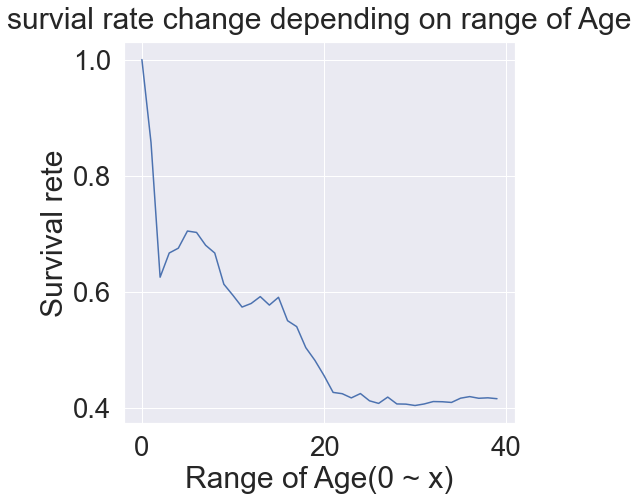

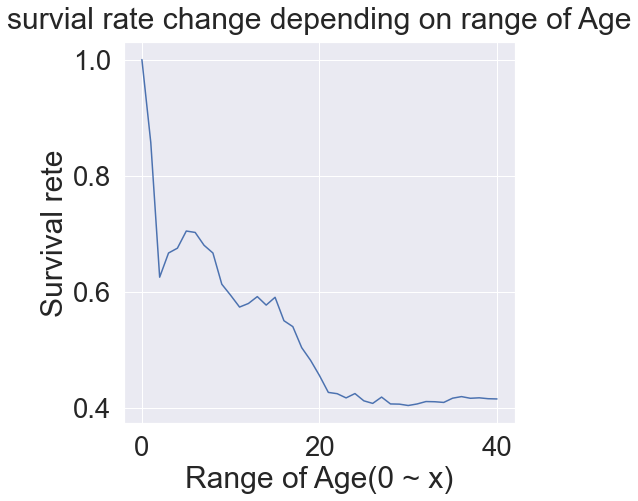

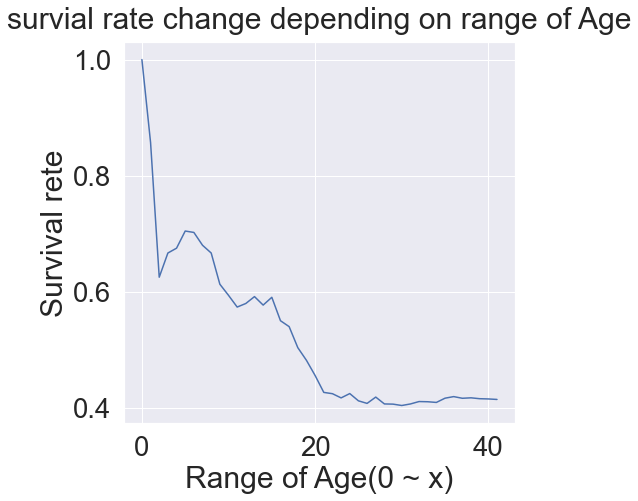

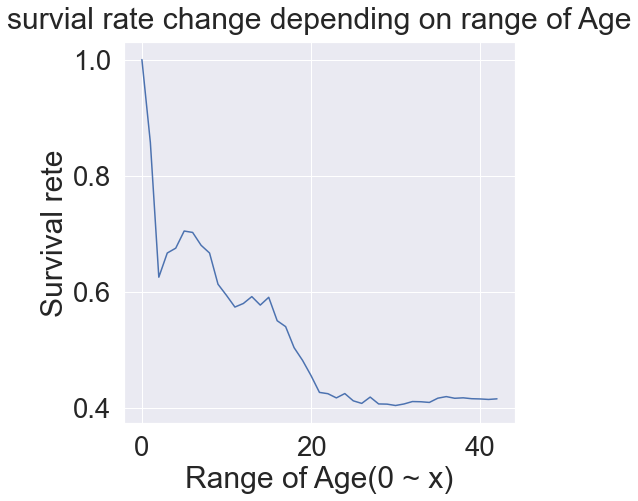

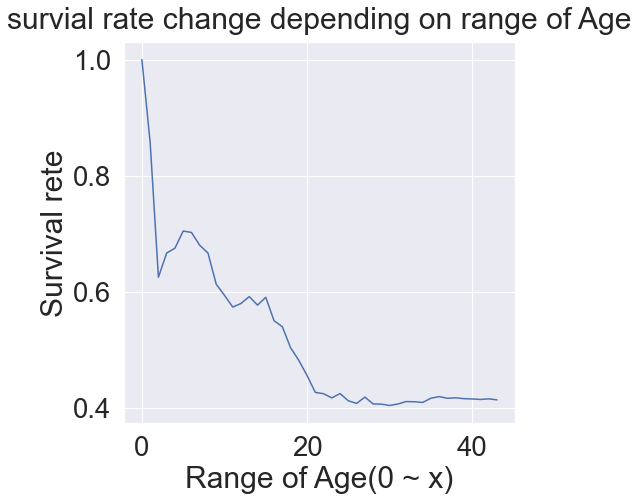

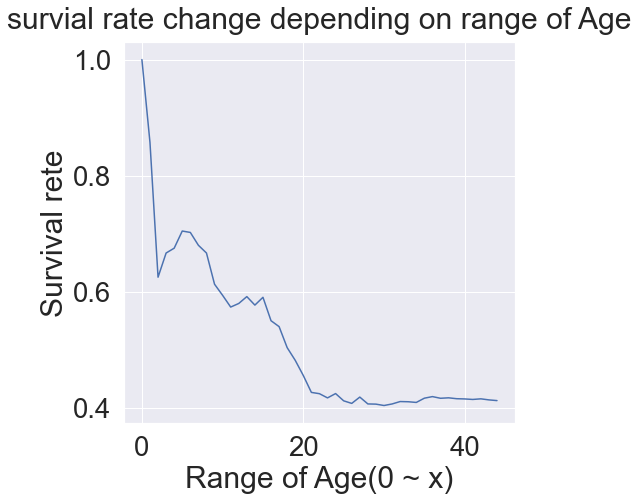

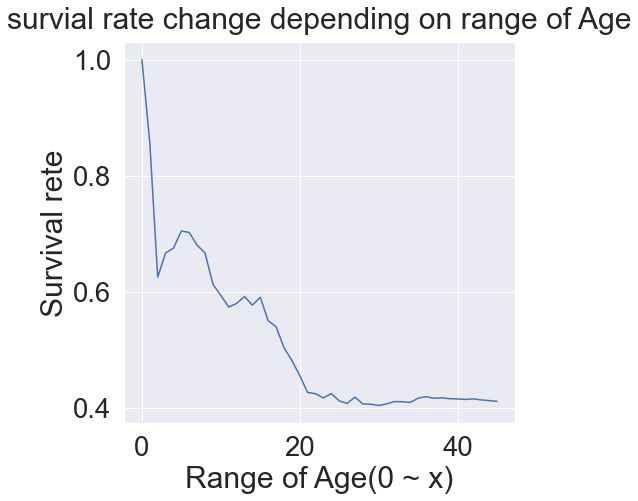

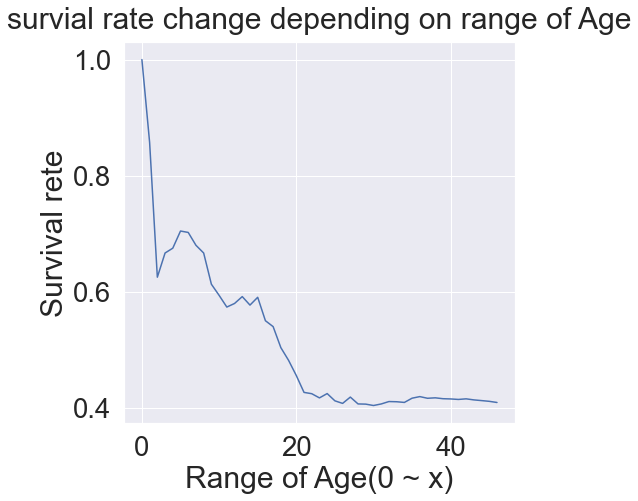

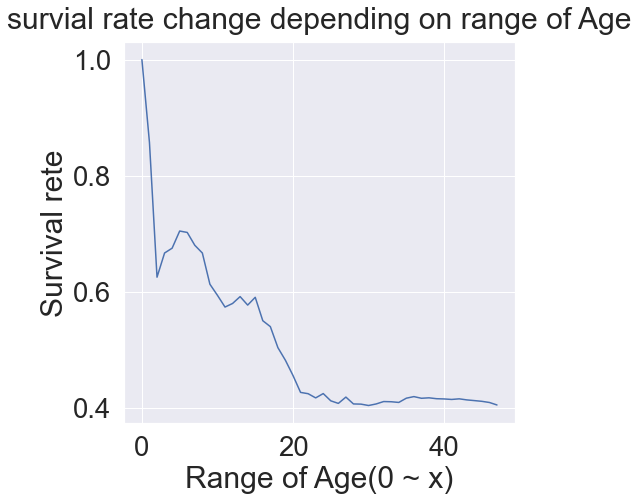

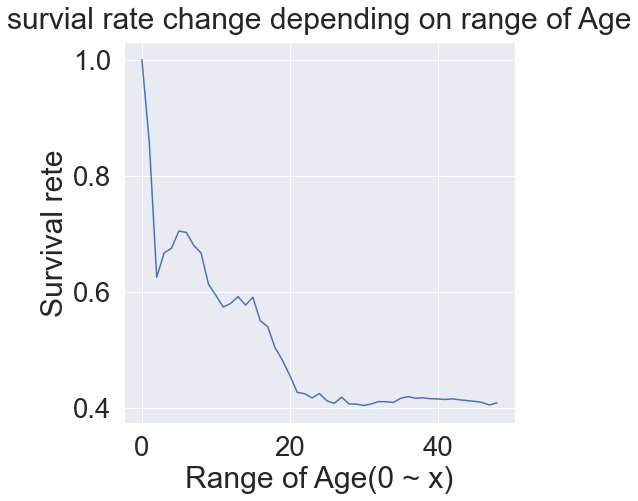

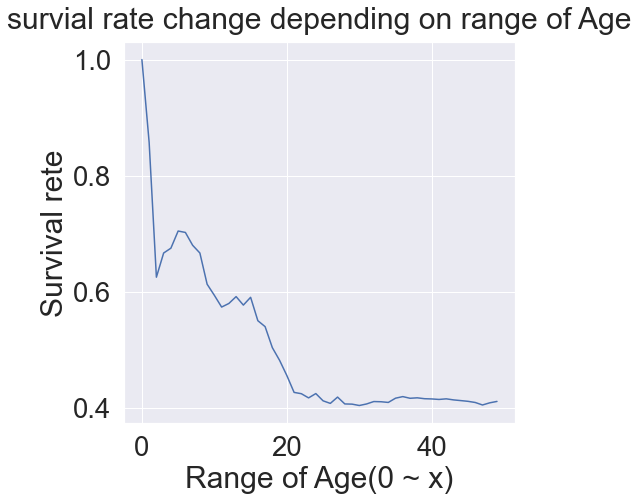

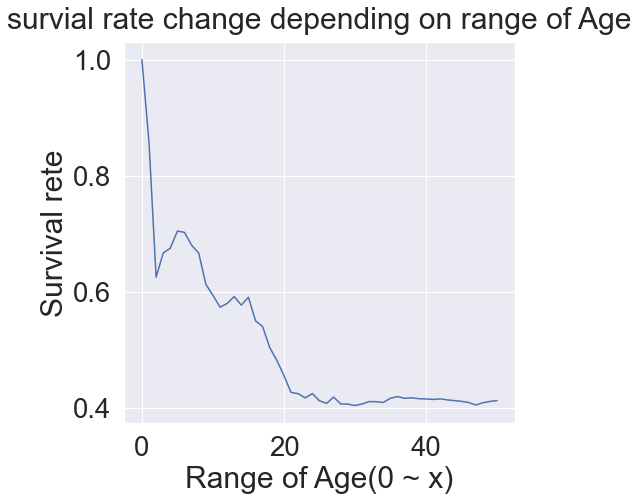

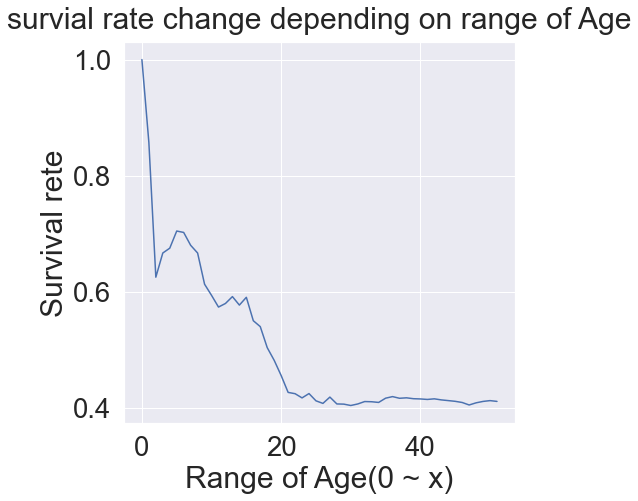

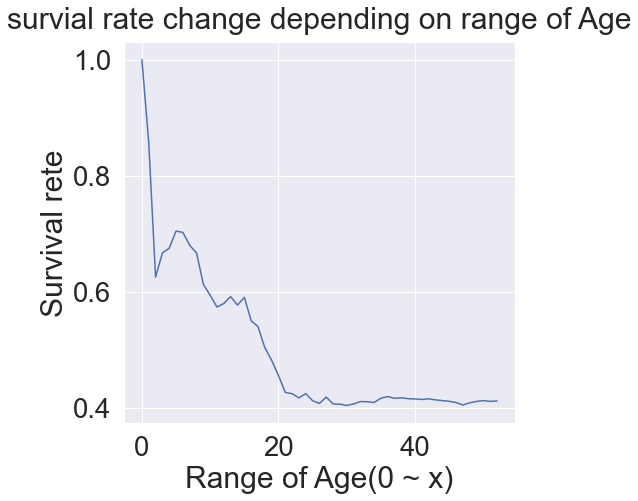

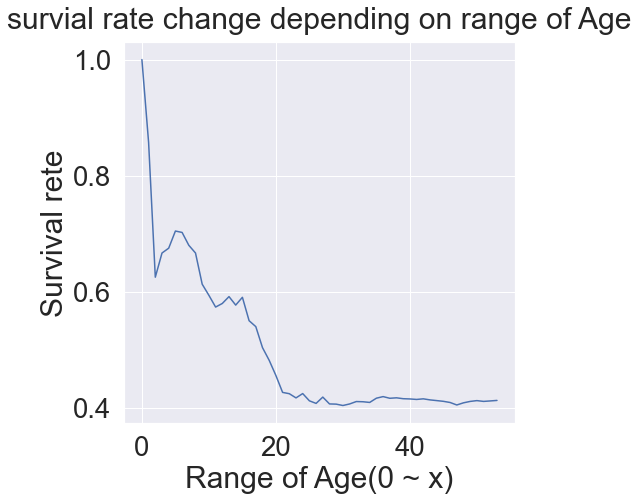

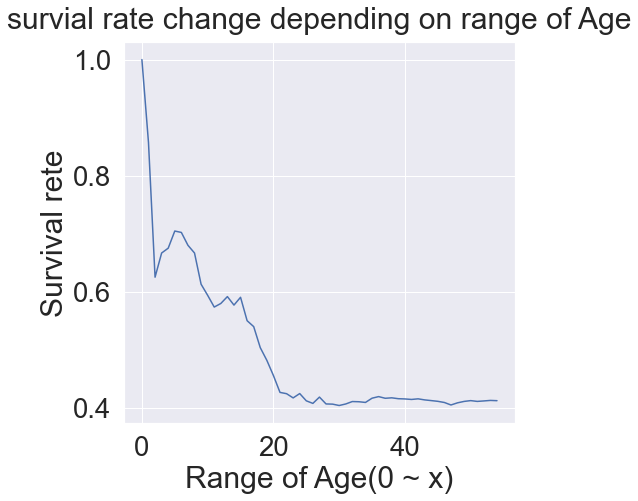

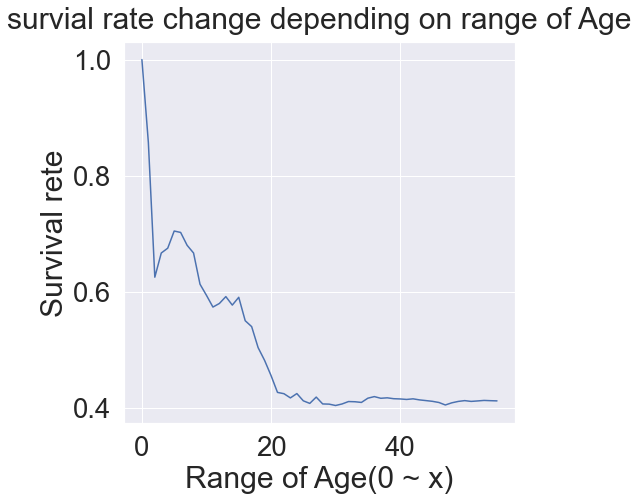

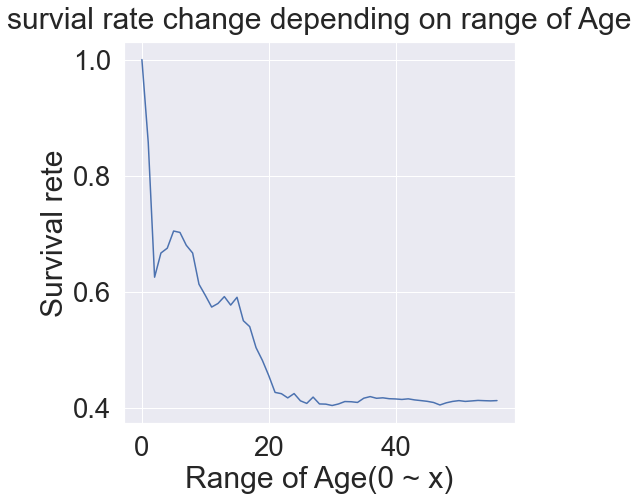

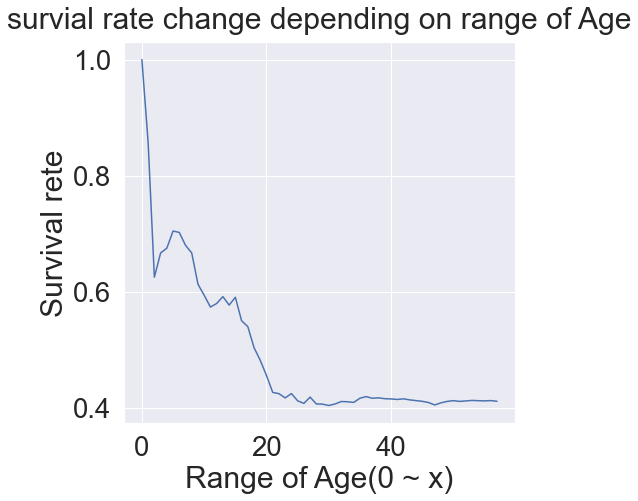

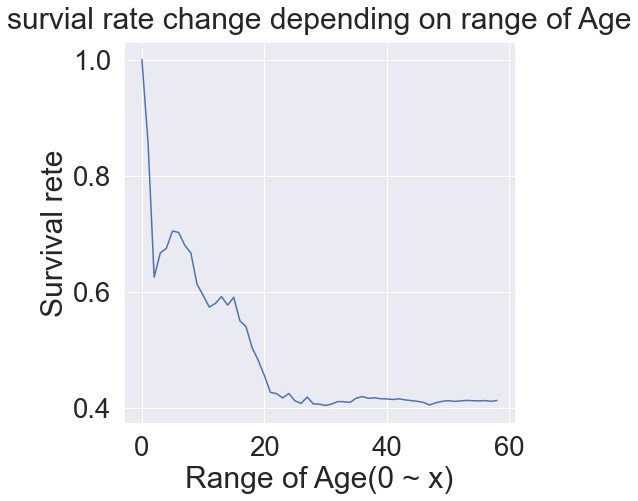

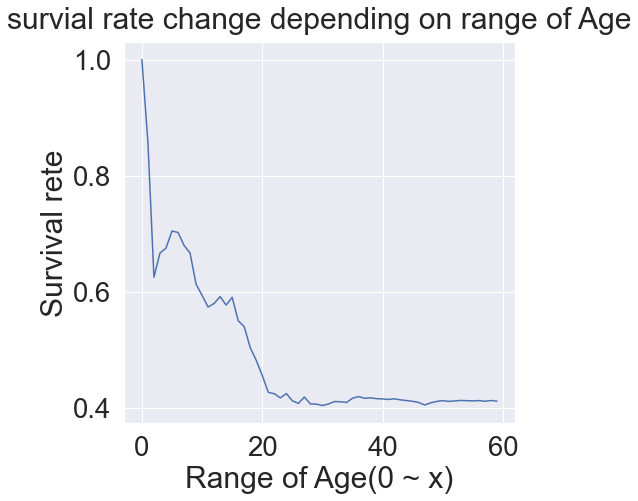

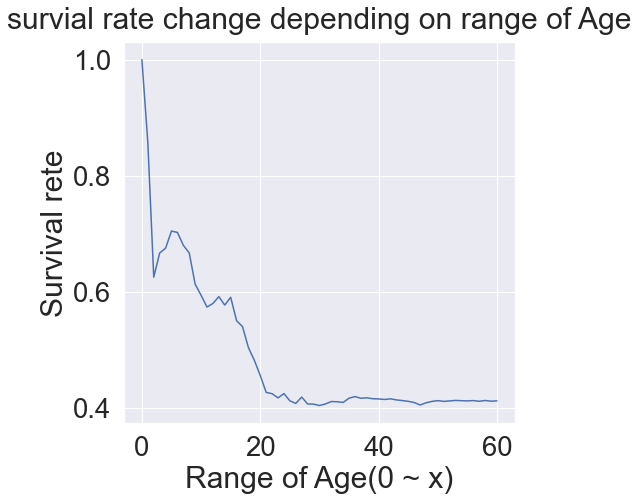

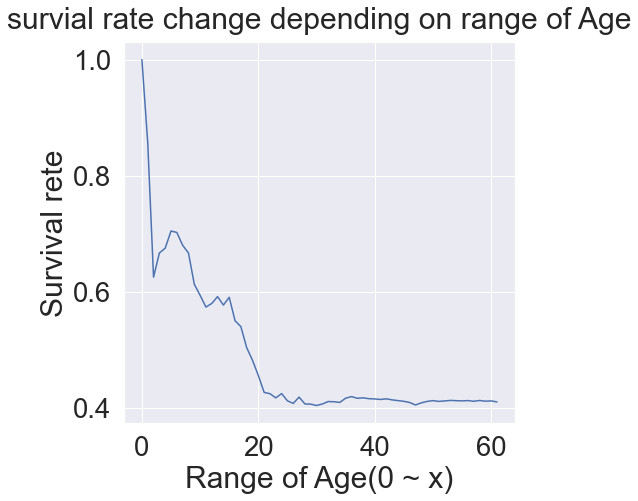

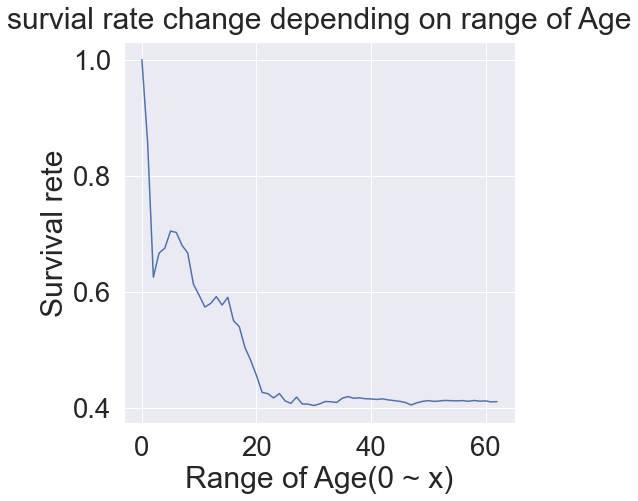

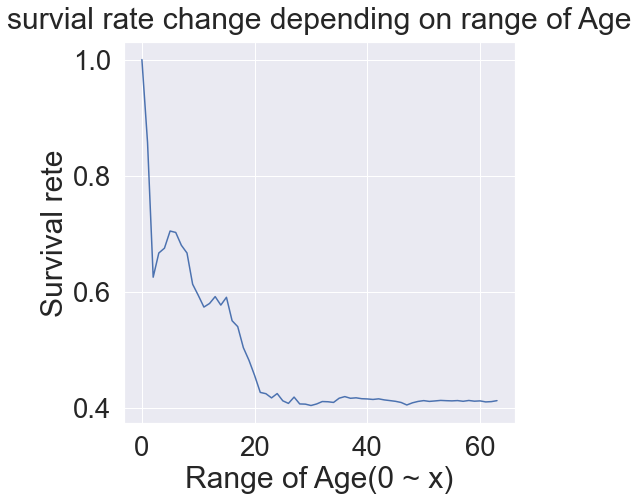

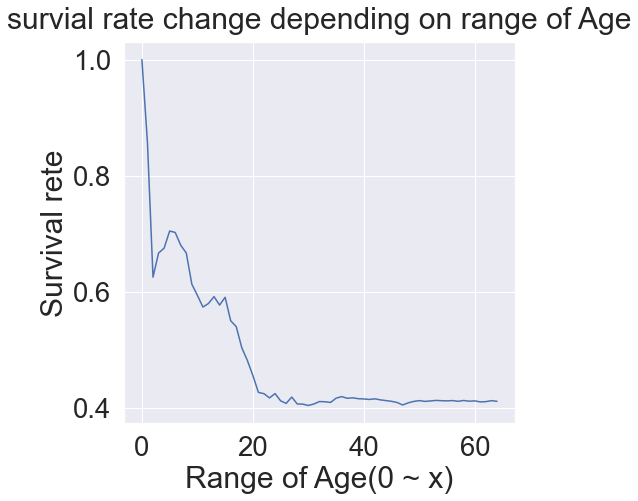

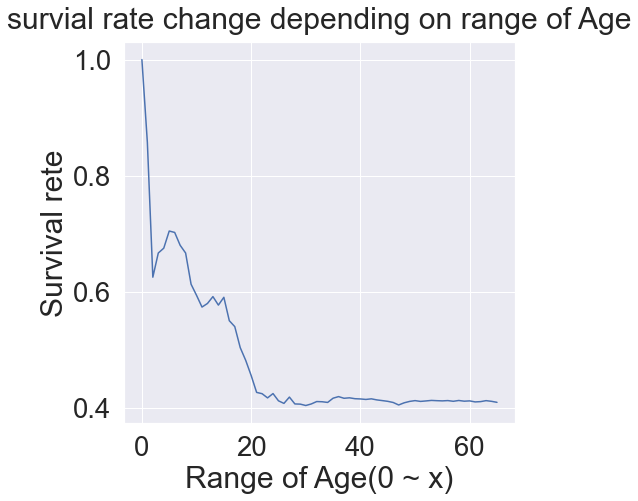

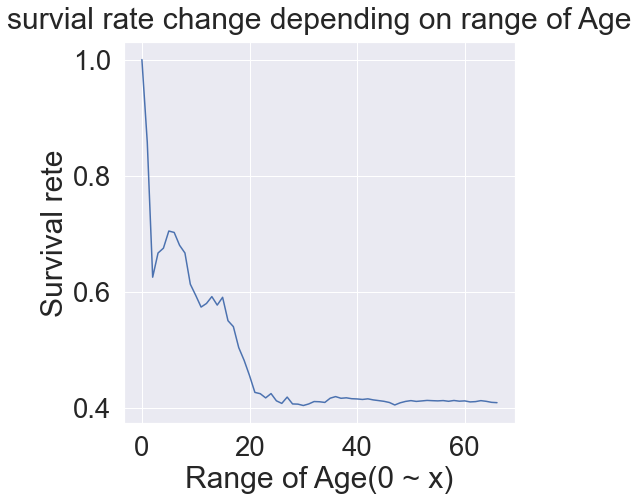

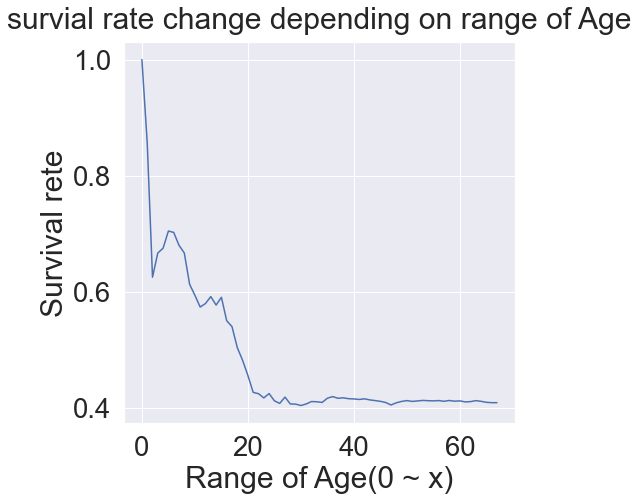

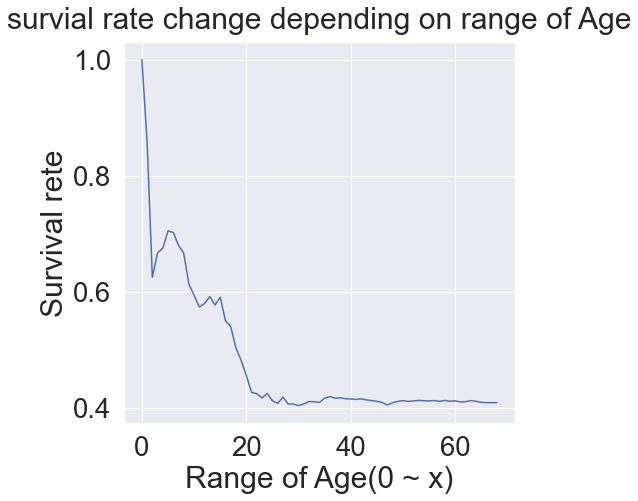

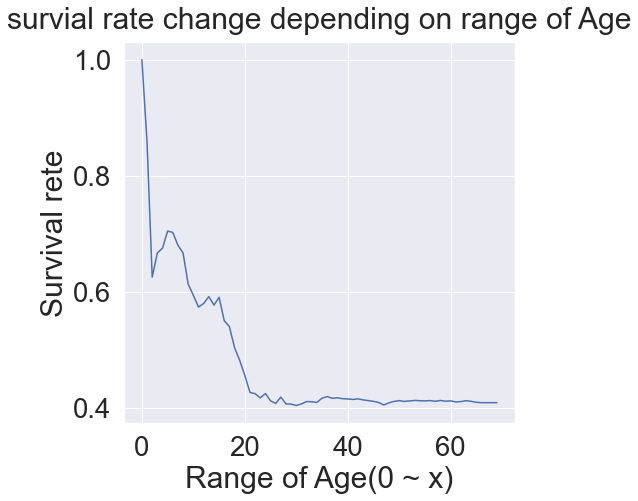

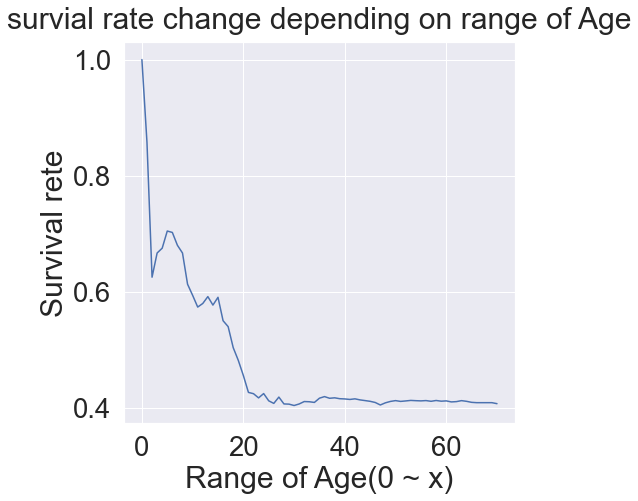

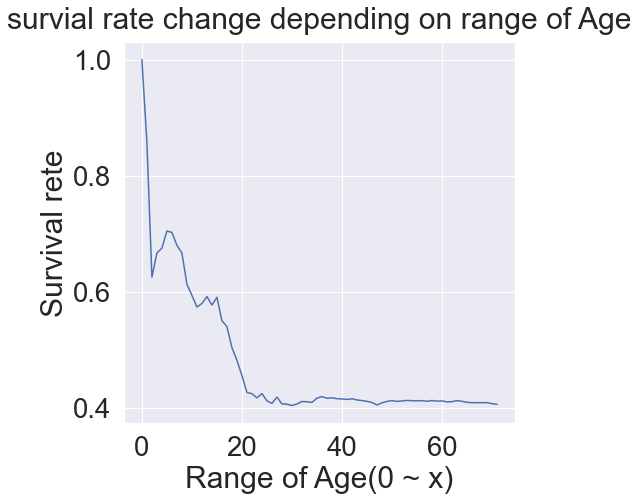

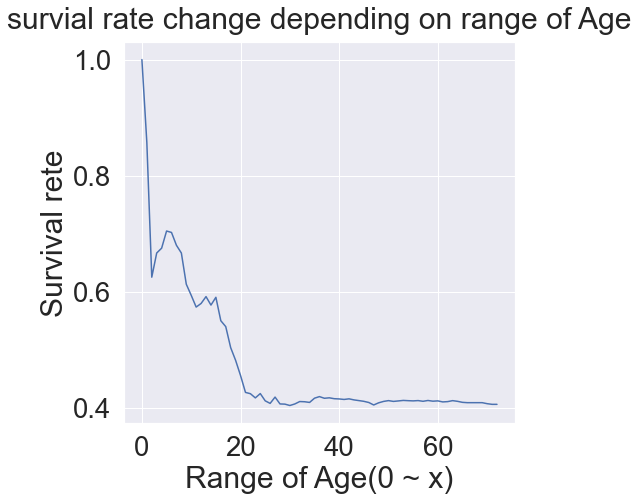

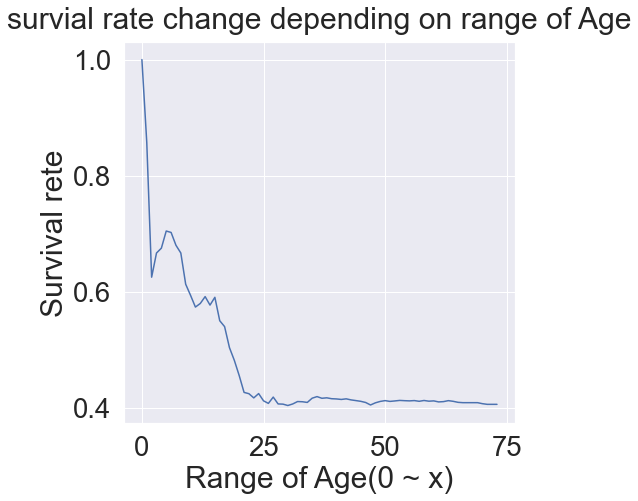

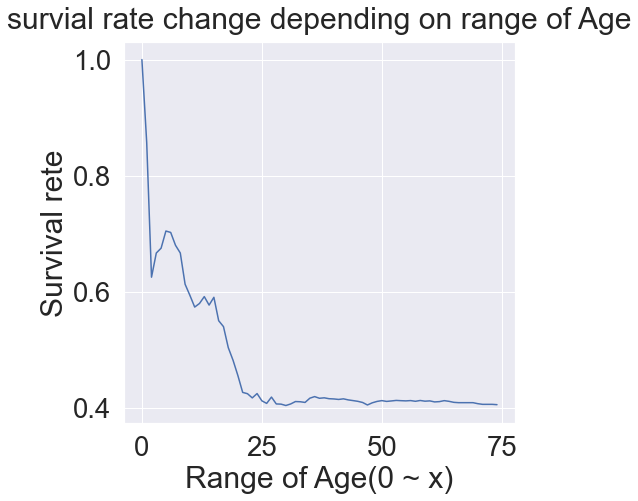

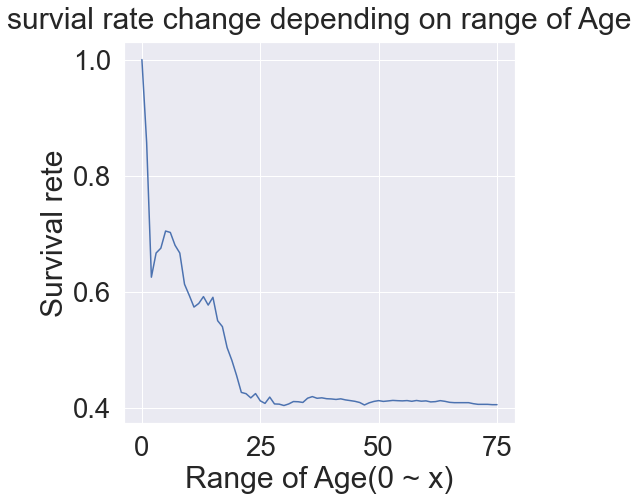

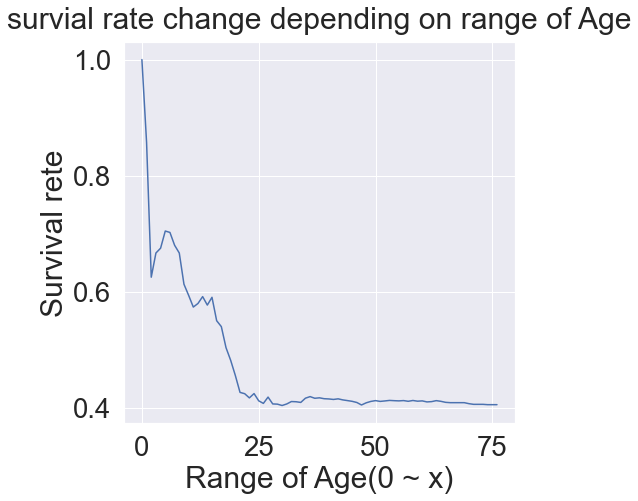

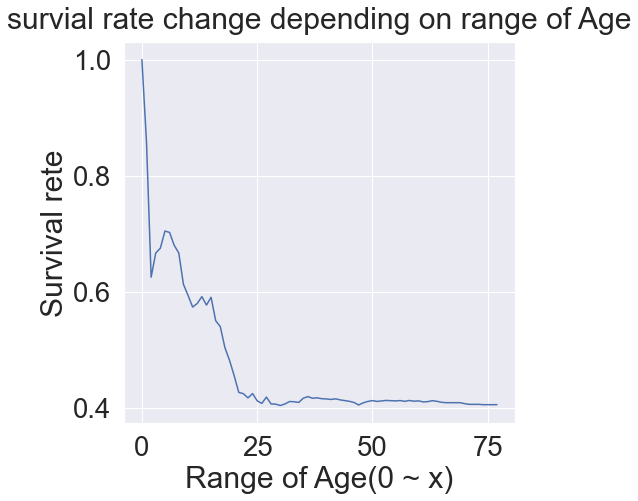

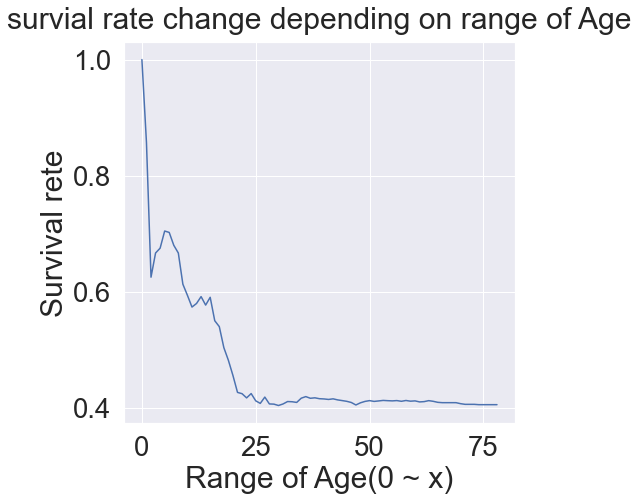

In [34]:
# 위 그래프에서 클래스가 높을수록 나이 연령대가 높아짐을 확인
# 나이대가 높음에 따라 생존확률이 어떻게 달라지는지 확인을 위해 누적 확률을 이용한 시각화 사용함.

cummulate_survival_ratio = []
for i in range(1, 80) :
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / len(df_train[df_train['Age'] < i]['Survived']))
    
    plt.figure(figsize = (7, 7))
    plt.plot(cummulate_survival_ratio)
    plt.title('survial rate change depending on range of Age', y = 1.02)
    plt.ylabel('Survival rete')
    plt.xlabel('Range of Age(0 ~ x)')
    plt.show()

In [35]:
# 나이가 어릴수록 생존률이 높은 것을 확인
# 나이도 중요한 특성(feature)임.

# 종합
# 여자이거나 나이가 어리거나 클래스가 높을 수록 생존률이 높다

In [36]:
# Embarked : 탑승 항구

df_train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

<AxesSubplot:xlabel='Embarked'>

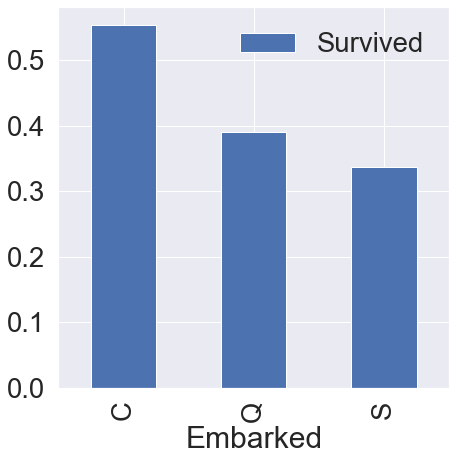

In [37]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)

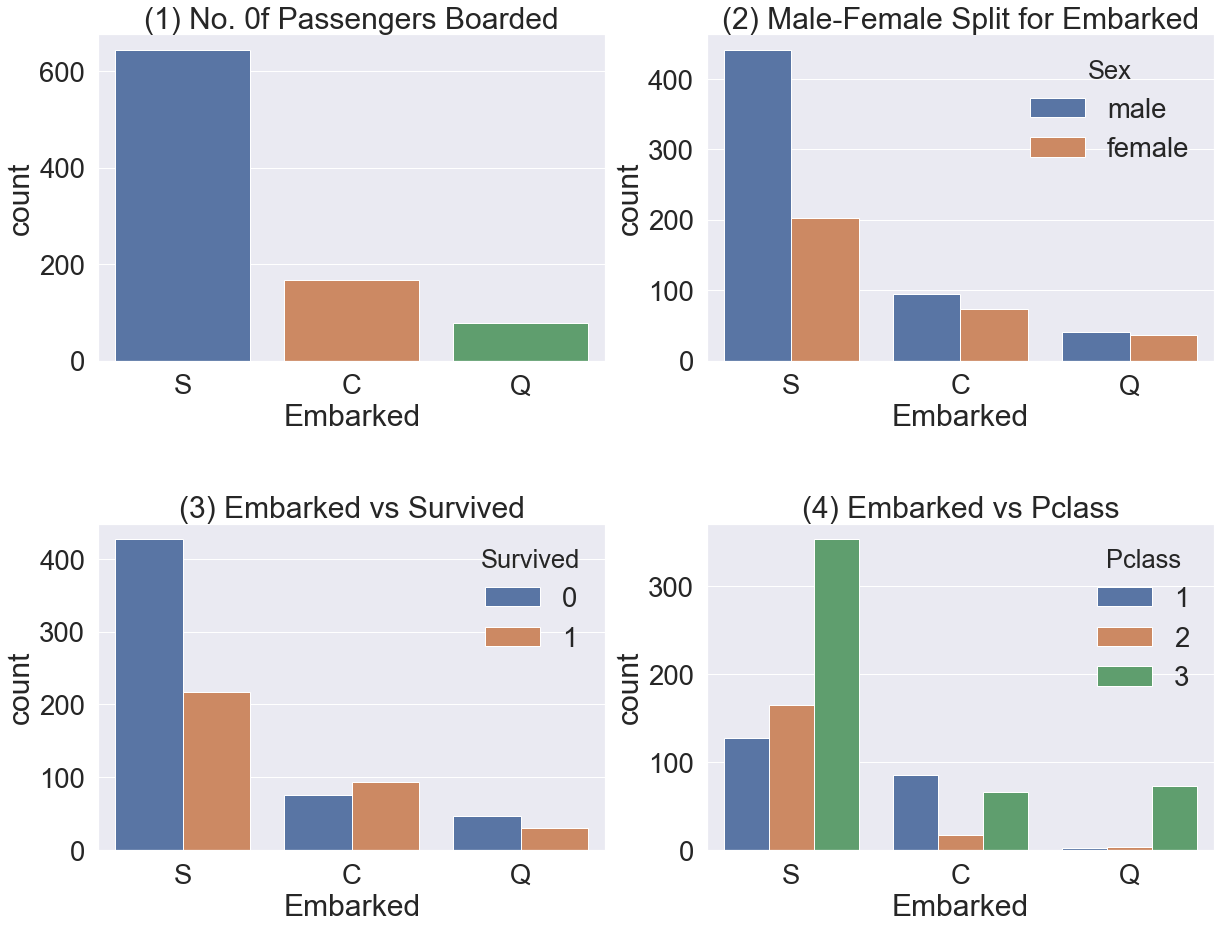

In [38]:
# 다른 특성(feature)와의 상관관계 알아보기

f, ax=plt.subplots(2, 2, figsize=(20, 15))
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. 0f Passengers Boarded')
sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0, 1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1, 0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [39]:
# Figure(1) : 전체적으로 S에서 가장 많은 사람이 탑승함
# Figure(2) : C와 Q는 남녀 비율이 비슷하고 S는 남자가 더 많다
# Figure(3) : 생존확률이 S경우 많이 낮음
# Figure(4) : Class로 split 해서 보니 C가 생존 확률이 높은건 클래스가
# 높은 사람이 많아서(S는 3rd class가 많아서 생존 확률이 낮게 나온다)

In [40]:
# Family-SibSp(형제 자매) + Parch(부모, 자녀)

df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch']+1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
 #자신을 포함해야돼서 1을 더함
    
print("Maximum size of Family: ", df_train['FamilySize'].max())
print("Minimum size of Family: ", df_train['FamilySize'].min())

Maximum size of Family:  11
Minimum size of Family:  1


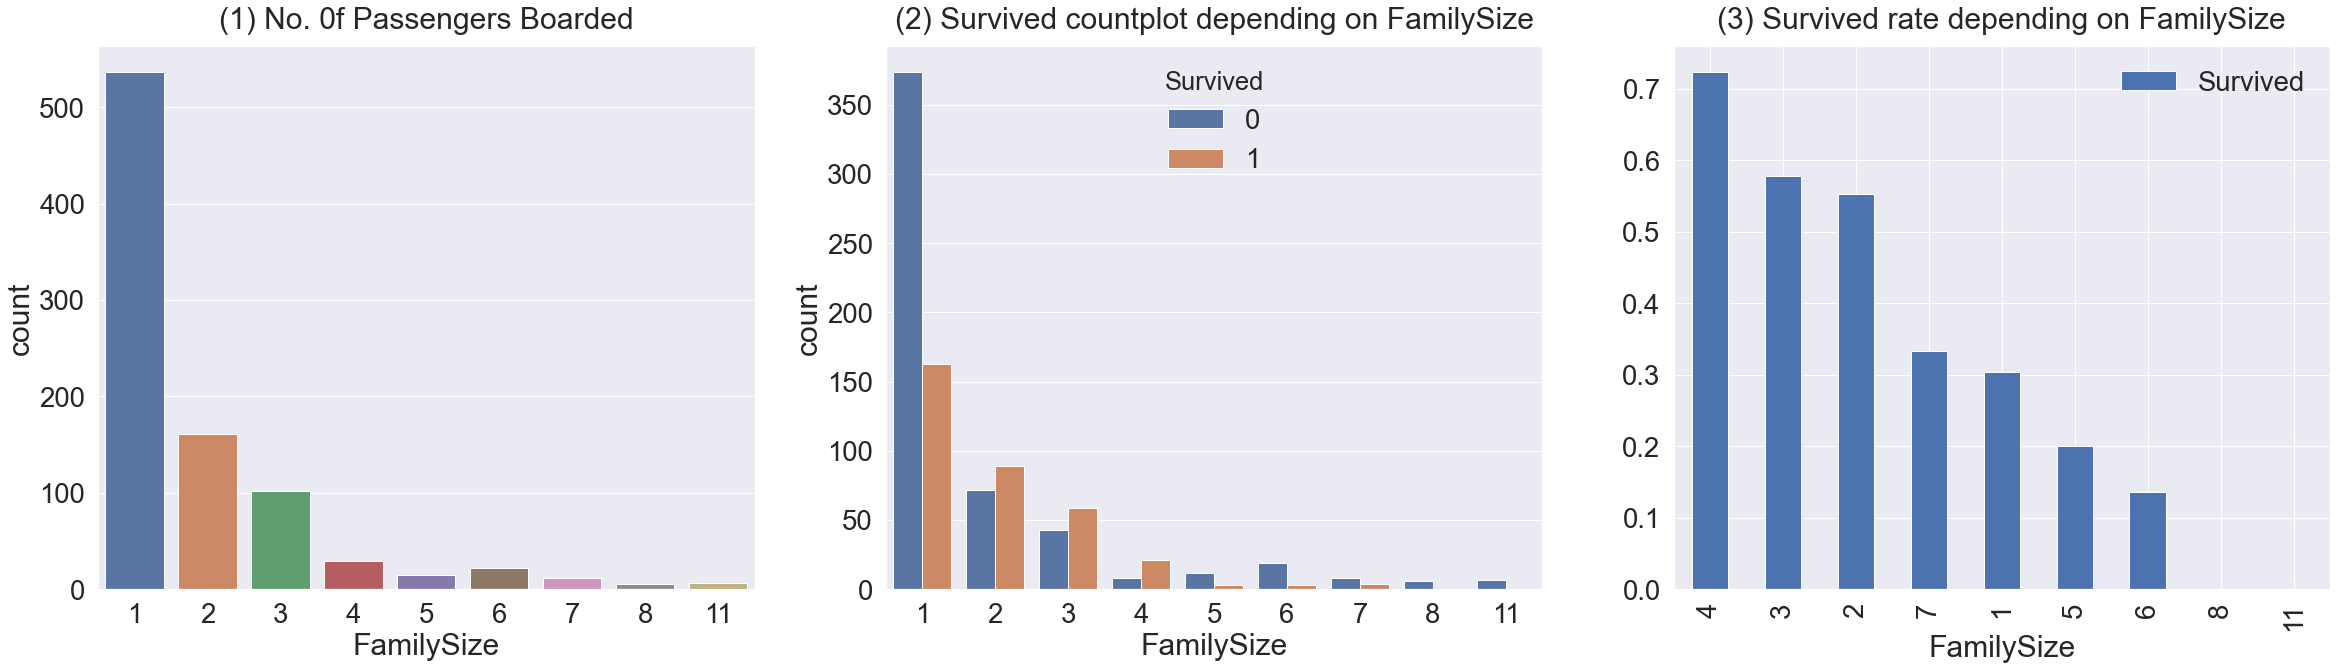

In [41]:
f, ax = plt.subplots(1, 3, figsize=(40, 10))
sns.countplot('FamilySize', data=df_train, ax=ax[0])
# countplot : 해당 카테고리 별 데이터 개수를 보여주는 그래프
ax[0].set_title('(1) No. 0f Passengers Boarded', y=1.02)

sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize', y=1.02)

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize', y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [42]:
# Figure(1) : 가족 크기가 1~11까지 있음을 볼수 있고 대부분 1명, 그다음으로 2, 3, 4
# Figure(2), (3) : 가족 크기에 따른 생존비교이다. 가족이 4명인 경우 생존률이 가장 높다
# 가족 수가 많아질수록 생존 확률이 낮아짐

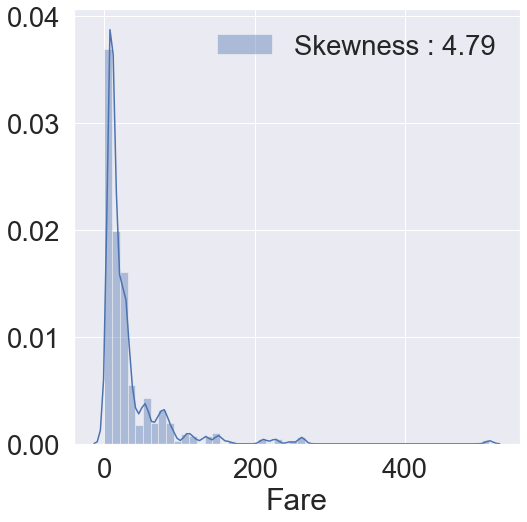

In [43]:
# Fare : 탑승 요금(연속적인 데이터 - 히스토그렘으로 그림)

flg, ax = plt.subplots(1, 1, figsize=(8, 8))
# subplots : 여러개의 그래프를 그리는 함수로 figure(전체 figure), axe(낱말 그래프)를 반환한다.
g = sns.distplot(df_train['Fare'], color ='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

In [44]:
# 특이하게 train set 말고 test set에 Fare 피쳐에 널 값이 하나 존재함
# 그래서 평균 값으로 해당 널값을 넣어줌
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()
# test set에 있는 nan value를 평균값으로 치환

df_train['Fare'] = df_train['Fare'].map(lambda i : np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

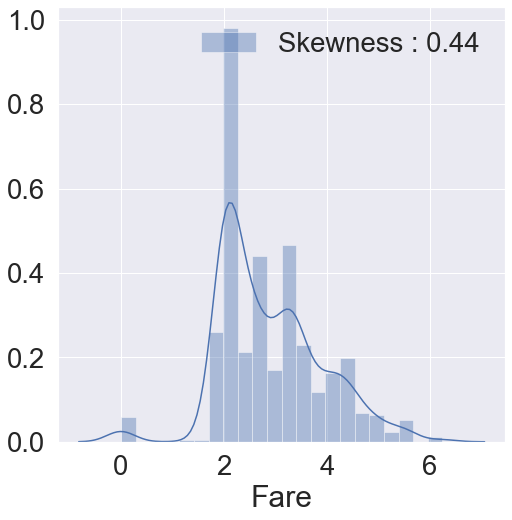

In [45]:
flg, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')